# Day 8 - Lab 1: Vision-Enabled UI/UX Agents

**Objective:** Use multi-modal vision models to generate a frontend UI from a design image, and then use a second agent to perform an automated design review.

**Estimated Time:** 90 minutes

**Introduction:**
Welcome to Day 8! Today, we'll explore one of the most exciting advancements in AI: vision. We will use a vision-capable model to act as a frontend developer, translating a design image directly into code. Then, we will create a second "UI/UX Critic" agent to automate the design review process, demonstrating a complete, AI-assisted frontend workflow.

For definitions of key terms used in this lab, please refer to the [GLOSSARY.md](../../GLOSSARY.md).

## Step 1: Setup

For this lab, we need to ensure we are using a vision-capable model. We will configure our `utils.py` helper to use a model like OpenAI's `gpt-4o` or Google's `gemini-2.5-pro`.

**Model Selection:**
This lab requires a vision-capable model. Excellent choices include `gpt-4o`, `gemini-2.5-pro`, or `deepseek-ai/DeepSeek-VL2`.

**Helper Functions Used:**
- `setup_llm_client()`: To configure the API client.
- `get_vision_completion()`: A specialized function to send an image and a text prompt to a vision model.
- `get_completion()`: To send text-only prompts for the refactoring step.
- `save_artifact()`: To save the generated code and the design review.

In [28]:
import sys
import os

# Add the project's root directory to the Python path
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
except IndexError:
    project_root = os.path.abspath(os.path.join(os.getcwd()))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_vision_completion, get_image_generation_completion, get_completion, save_artifact, clean_llm_output, recommended_models_table
from IPython.display import Image, display, Code

image_client, image_model_name, image_api_provider = setup_llm_client(model_name="gemini-2.0-flash-preview-image-generation")
print(f"✅ Using {image_model_name} for image generation")

# Ensure you select a vision-capable model
vision_client, vision_model_name, vision_api_provider = setup_llm_client(model_name="gpt-5-2025-08-07")
print(f"✅ Using {vision_model_name} for vision tasks")


if not image_model_name or not vision_model_name:
    print("Could not set up a valid LLM client. Please check your .env file and utils.py configuration.")

✅ LLM Client configured: Using 'google' with model 'gemini-2.0-flash-preview-image-generation'
✅ Using gemini-2.0-flash-preview-image-generation for image generation
✅ LLM Client configured: Using 'openai' with model 'gpt-5-2025-08-07'
✅ Using gpt-5-2025-08-07 for vision tasks


In [5]:
recommended_models_table()

| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |
|---|---|---|---|---|---|---|---|---|
| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| claude-opus-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| dall-e-3 | openai | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |
| gemini-1.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 8,192 |
| gemini-1.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 2,000,000 | 8,192 |
| gemini-2.0-flash-exp | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ❌ | ❌ | 32,000 | 8,192 |
| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ❌ | ❌ | 32,768 | 32,768 |
| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-live-2.5-flash-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gpt-4.1 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,768 |
| gpt-4.1-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4.1-nano | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4o | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-5-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-mini-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-nano-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| meta-llama/Llama-3.3-70B-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 8,192 | 4,096 |
| meta-llama/Llama-4-Maverick-17B-128E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| meta-llama/Llama-4-Scout-17B-16E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 10,000,000 | 100,000 |
| mistralai/Mistral-7B-Instruct-v0.3 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 32,768 | 8,192 |
| o3 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| o4-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| stabilityai/stable-diffusion-3.5-large | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| tokyotech-llm/Llama-3.1-Swallow-8B-Instruct-v0.5 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| veo-3.0-fast-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| veo-3.0-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| whisper-1 | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |

'| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |\n|---|---|---|---|---|---|---|---|---|\n| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |\n| claude-opus-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |\n| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |\n| dall-e-3 | openai | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |\n| gemini-1.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 8,192 |\n| gemini-1.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 2,000,000 | 8,192 |\n| gemini-2.0-flash-exp | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |\n| gemini-2.0-flash-preview

## Step 2: The Design Screenshot

This is the design we want our AI agent to build. It's a simple login form component. We will provide the URL to this image directly to the model.

Using gemini-2.0-flash-preview-image-generation for image generation...
Generating image... This may take a moment.


⏳ Generating image...

✅ Image generated in 3.81 seconds.
✅ Image saved to: artifacts\artifacts\screens\image_1757098532874.png
✅ Generated image saved to: C:\Users\labadmin\Documents\ag-aisoftdev\Labs\Day_08_Vision_and_Evaluation\artifacts\artifacts\screens\image_1757098532874.png



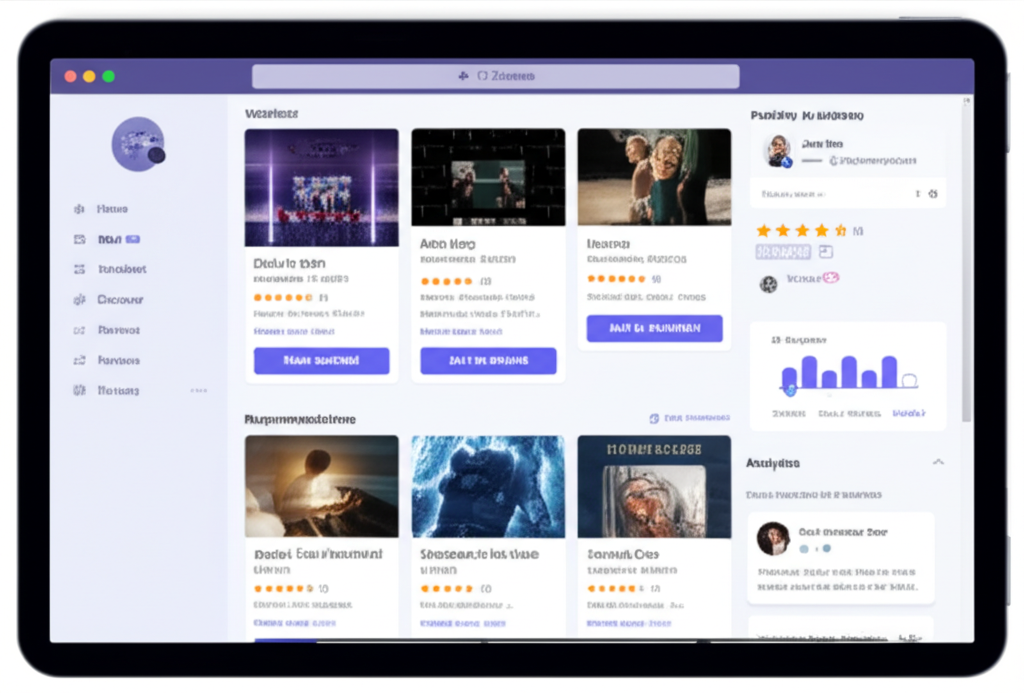

In [30]:
screen_generation_prompt = "Design a web application dashboard for a Movie & TV Show Management platform — 16:9, browser window mockup at 1920x1080. Center a modern browser frame with rounded corners and soft shadow. Top header: app title 'MyCinema' (or placeholder), compact avatar, and a search bar. Three-column layout: left rail with vertical nav (Home, Watchlist, Discover, Reviews); main column with a Watchlist card showing poster thumbnails, title, star ratings, progress badges and a prominent 'Mark watched' button; a Recommendations/Discovery grid with large poster cards, genre tags and CTA 'Add to Watchlist'; right column with Profile & Activity card (recent reviews with short snippets, quick-rate stars) and an Analytics card showing a small bar/line chart 'Hours watched' and 'Top genres'. UI style: clean Tailwind-like design, white cards on soft blue-gray background, indigo/teal/purple accents, subtle 1px borders, 8–12px radii, crisp sans-serif typography (Inter/Roboto), realistic spacing and micro-shadows. Include interface elements for writing a short review (input + star rating), share/comment icons, and a small live indicator for new recommendations. Show sample text: 'Jane Doe — jane@example.com', sample movie titles and star ratings. No real logos or copyrighted marks, no photographic people (use illustrated avatars or initials). Render as a marketing-quality UI mockup: vector-like clarity, crisp details, high contrast, realistic lighting, with high definination graphics and real text lables."

print(f"Using {image_model_name} for image generation...")
file_path, image_url = get_image_generation_completion(screen_generation_prompt, image_client, image_model_name, image_api_provider)

# Display the generated image if successful
if file_path and image_url:
    print(f"✅ Generated image saved to: {file_path}")
    display(Image(url=image_url))
elif image_url:
    print(f"❌ Image generation failed: {image_url}")
else:
    print("❌ Image generation returned no result")

In [4]:
recommended_models_table()

| Model | Provider | Vision | Image Gen | Audio Transcription | Context Window | Max Output Tokens |
|---|---|---|---|---|---|---|
| claude-opus-4-1-20250805 | anthropic | ✅ | ❌ | ❌ | 200,000 | 100,000 |
| claude-opus-4-20250514 | anthropic | ✅ | ❌ | ❌ | 200,000 | 100,000 |
| claude-sonnet-4-20250514 | anthropic | ✅ | ❌ | ❌ | 1,000,000 | 100,000 |
| codex-mini-latest | openai | ✅ | ❌ | ❌ | 200,000 | 100,000 |
| dall-e-3 | openai | ❌ | ✅ | ❌ | - | - |
| deepseek-ai/DeepSeek-V3 | huggingface | ❌ | ❌ | ❌ | 128,000 | 100,000 |
| deepseek-ai/DeepSeek-V3-Small | huggingface | ❌ | ❌ | ❌ | 128,000 | 100,000 |
| deepseek-ai/DeepSeek-VL2 | huggingface | ✅ | ❌ | ❌ | 32,000 | 8,000 |
| deepseek-ai/DeepSeek-VL2-Small | huggingface | ✅ | ❌ | ❌ | 32,000 | 8,000 |
| deepseek-ai/DeepSeek-VL2-Tiny | huggingface | ✅ | ❌ | ❌ | 32,000 | 8,000 |
| deepseek-ai/Janus-Pro-7B | huggingface | ✅ | ❌ | ❌ | 0 | 0 |
| gemini-2.0-flash | google | ✅ | ❌ | ❌ | 1,048,576 | 8,192 |
| gemini-2.0-flash-lite | google | ✅ | ❌ | ❌ | 1,048,576 | 8,192 |
| gemini-2.0-flash-live-001 | google | ✅ | ❌ | ❌ | 1,048,576 | 8,192 |
| gemini-2.5-flash | google | ✅ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-flash-image-preview | google | ✅ | ✅ | ❌ | 32,768 | 32,768 |
| gemini-2.5-flash-lite | google | ✅ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-pro | google | ✅ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-live-2.5-flash-preview | google | ✅ | ❌ | ❌ | 1,048,576 | 8,192 |
| gemini-veo-3 | google | ✅ | ❌ | ❌ | - | - |
| google-cloud/speech-to-text/latest_long | google | ❌ | ❌ | ✅ | - | - |
| google-cloud/speech-to-text/latest_short | google | ❌ | ❌ | ✅ | - | - |
| gpt-4.1 | openai | ✅ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4.1-mini | openai | ✅ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4.1-nano | openai | ✅ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4.5 | openai | ✅ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o | openai | ✅ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini | openai | ✅ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-5-2025-08-07 | openai | ✅ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-mini-2025-08-07 | openai | ✅ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-nano-2025-08-07 | openai | ✅ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-image-1 | openai | ✅ | ✅ | ❌ | - | - |
| imagen-3.0-capability-001 | google | ❌ | ❌ | ❌ | - | - |
| imagen-3.0-fast-generate-001 | google | ❌ | ✅ | ❌ | - | - |
| imagen-3.0-generate-001 | google | ❌ | ✅ | ❌ | - | - |
| imagen-3.0-generate-002 | google | ❌ | ✅ | ❌ | - | - |
| imagen-4.0-fast-generate-001 | google | ❌ | ✅ | ❌ | 480 | - |
| imagen-4.0-generate-001 | google | ❌ | ✅ | ❌ | 480 | - |
| imagen-4.0-ultra-generate-001 | google | ❌ | ✅ | ❌ | 480 | - |
| meta-llama/Llama-3.3-70B-Instruct | huggingface | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| meta-llama/Llama-4-Maverick-17B-128E-Instruct | huggingface | ✅ | ❌ | ❌ | 1,000,000 | 100,000 |
| meta-llama/Llama-4-Scout-17B-16E-Instruct | huggingface | ✅ | ❌ | ❌ | 10,000,000 | 100,000 |
| mistralai/Mistral-7B-Instruct-v0.3 | huggingface | ❌ | ❌ | ❌ | 32,768 | 8,192 |
| o3 | openai | ✅ | ❌ | ❌ | 200,000 | 100,000 |
| o4-mini | openai | ✅ | ❌ | ❌ | 200,000 | 100,000 |
| tokyotech-llm/Llama-3.1-Swallow-70B-Instruct-v0.3 | huggingface | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| tokyotech-llm/Llama-3.1-Swallow-8B-Instruct-v0.5 | huggingface | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| whisper-1 | openai | ❌ | ❌ | ✅ | - | - |

'| Model | Provider | Vision | Image Gen | Audio Transcription | Context Window | Max Output Tokens |\n|---|---|---|---|---|---|---|\n| claude-opus-4-1-20250805 | anthropic | ✅ | ❌ | ❌ | 200,000 | 100,000 |\n| claude-opus-4-20250514 | anthropic | ✅ | ❌ | ❌ | 200,000 | 100,000 |\n| claude-sonnet-4-20250514 | anthropic | ✅ | ❌ | ❌ | 1,000,000 | 100,000 |\n| codex-mini-latest | openai | ✅ | ❌ | ❌ | 200,000 | 100,000 |\n| dall-e-3 | openai | ❌ | ✅ | ❌ | - | - |\n| deepseek-ai/DeepSeek-V3 | huggingface | ❌ | ❌ | ❌ | 128,000 | 100,000 |\n| deepseek-ai/DeepSeek-V3-Small | huggingface | ❌ | ❌ | ❌ | 128,000 | 100,000 |\n| deepseek-ai/DeepSeek-VL2 | huggingface | ✅ | ❌ | ❌ | 32,000 | 8,000 |\n| deepseek-ai/DeepSeek-VL2-Small | huggingface | ✅ | ❌ | ❌ | 32,000 | 8,000 |\n| deepseek-ai/DeepSeek-VL2-Tiny | huggingface | ✅ | ❌ | ❌ | 32,000 | 8,000 |\n| deepseek-ai/Janus-Pro-7B | huggingface | ✅ | ❌ | ❌ | 0 | 0 |\n| gemini-2.0-flash | google | ✅ | ❌ | ❌ | 1,048,576 | 8,192 |\n| gemini-2.0-flash-lite 

In [31]:
login_form_url = "https://imgur.com/h7ThOlA.png"
display(Image(url=login_form_url))

## Step 3: The Challenges

### Challenge 1 (Foundational): Generating a Monolithic UI Component

**Task:** Use the vision model to generate a single, self-contained React component that replicates the design from the image.

> **Tip for Vision Prompts:** Be specific about the output format. Telling the model you want 'React' and 'Tailwind CSS' is crucial. The more specific your technical constraints, the better the generated code will be.

**Instructions:**
1.  Create a prompt that asks the vision model to act as an expert frontend developer.
2.  The prompt should instruct the model to analyze the image at the provided URL.
3.  Ask it to generate a single React component using Tailwind CSS for styling.
4.  The output should be a single block of JSX code.

**Expected Quality:** A single file's worth of React code that, when rendered, visually approximates the login form in the screenshot.

In [32]:
# Explain the specified image using the vision-capable LLM
image_path = r"https://imgur.com/h7ThOlA.png"

explain_image_prompt = f"""
You are an expert frontend developer and UI/UX designer. Analyze the provided design image and the Product Requirements (Movie & TV Show Management platform). Produce exactly one React functional component as a single block of JSX code only (no surrounding text, no imports, no comments). The component must be named MyCinemaDashboard, export default, and be self-contained: include inline sample data arrays for watchlist and recommendations and use placeholder images for posters. Style everything exclusively with Tailwind CSS utility classes. Requirements for the JSX output:

Layout: responsive, three-column desktop layout with left navigation rail, central Watchlist + Discovery area, and right-side Profile/Activity + Analytics card. Mobile-first classes must collapse to a single column.
Header: show app title 'MyCinema', a centered search bar, and a compact profile avatar (initials).
Watchlist card: movie genre tags with icons, title, star rating display, progress badge, and a 'Mark watched' button. Provide interactive state with React hooks so clicking 'Mark watched' updates state and UI.
Recommendations grid: poster cards with genre tags and an 'Add to Watchlist' button that updates the watchlist state.
Right column: recent reviews/activity list and a small analytics placeholder (inline SVG chart or simple bars).
Accessibility: use semantic tags, aria-labels for interactive controls, focus-visible styles, and meaningful button text.
Interactivity: use useState/useEffect where needed, minimal inline handlers (no external APIs), and sample data in the component body.
Visuals: clean Tailwind look (white rounded cards, soft shadows, indigo/teal accents), readable typography, 8–12px radii, and subtle spacing.
Do not include any CSS outside Tailwind classes, do not reference external images except placeholder URLs (e.g., https://via.placeholder.com/), and do not output any text other than the single JSX component block.
Return ONLY the JSX component code block that meets the above constraints."
"""

print("--- Requesting image explanation from vision model ---")
if vision_model_name:
    explanation = get_vision_completion(explain_image_prompt, image_path, vision_client, vision_model_name, vision_api_provider)
    cleaned_explanation = clean_llm_output(explanation, language="markdown")
    display(Code(cleaned_explanation, language="markdown"))
    # Save the explanation for later reference
    save_artifact(cleaned_explanation, "artifacts/image_explanation.md")
else:
    print("Skipping image explanation because no vision model is configured.")

--- Requesting image explanation from vision model ---


export default function MyCinemaDashboard() {
  const [query, setQuery] = React.useState("");
  const userName = "Ava Sloan";
  const initials = userName.split(" ").map(n => n[0]).slice(0,2).join("").toUpperCase();
  const genreIcons = {
    "Sci‑Fi":"🛸",
    "Thriller":"🧩",
    "Action":"⚔️",
    "Crime":"🕵️",
    "Drama":"🎭",
    "Adventure":"🧭",
    "Animation":"🎨",
    "Superhero":"🦸"
  };
  const [watchlist, setWatchlist] = React.useState([
    { id: 1, title: "Inception", genres: ["Sci‑Fi","Thriller"], rating: 4.5, progress: 40, watched: false, poster: "https://via.placeholder.com/300x450?text=Inception" },
    { id: 2, title: "The Batman", genres: ["Action","Crime"], rating: 4.0, progress: 10, watched: false, poster: "https://via.placeholder.com/300x450?text=The+Batman" },
    { id: 3, title: "Stranger Things S1", genres: ["Sci‑Fi","Drama"], rating: 4.7, progress: 80, watched: false, poster: "https://via.placeholder.com/300x450?text=Stranger+Things" }
  ]);
  const [recommendations] = React.useState([
    { id: 101, title: "Dune: Part One", genres: ["Sci‑Fi","Adventure"], rating: 4.3, poster: "https://via.placeholder.com/300x450?text=Dune" },
    { id: 102, title: "Arcane", genres: ["Animation","Action"], rating: 4.8, poster: "https://via.placeholder.com/300x450?text=Arcane" },
    { id: 103, title: "Interstellar", genres: ["Sci‑Fi","Drama"], rating: 4.6, poster: "https://via.placeholder.com/300x450?text=Interstellar" },
    { id: 104, title: "The Bear", genres: ["Drama"], rating: 4.2, poster: "https://via.placeholder.com/300x450?text=The+Bear" },
    { id: 105, title: "Spider‑Verse", genres: ["Animation","Superhero"], rating: 4.7, poster: "https://via.placeholder.com/300x450?text=Spider-Verse" }
  ]);
  const [activity, setActivity] = React.useState([
    { id:"a1", text:"You reviewed Interstellar: ★★★★★", time:"2h ago" },
    { id:"a2", text:"Followed Casey who likes Sci‑Fi", time:"1d ago" }
  ]);
  const [liveMessage, setLiveMessage] = React.useState("");
  React.useEffect(() => {
    if (!liveMessage) return;
    const t = setTimeout(() => setLiveMessage(""), 2000);
    return () => clearTimeout(t);
  }, [liveMessage]);
  const inWatchlistTitles = new Set(watchlist.map(w => w.title));
  const filteredRecs = recommendations.filter(r => r.title.toLowerCase().includes(query.toLowerCase()));
  function renderStars(value) {
    const full = Math.round(value);
    return (
      <div className="flex" aria-label={`Rating ${value} out of 5`}>
        {[1,2,3,4,5].map(i => (
          <svg key={i} className={`h-4 w-4 ${i<=full ? "text-yellow-400" : "text-slate-300"}`} viewBox="0 0 20 20" fill="currentColor" aria-hidden="true">
            <path d="M9.049 2.927c.3-.921 1.603-.921 1.902 0l1.07 3.292a1 1 0 00.95.69h3.462c.969 0 1.371 1.24.588 1.81l-2.801 2.034a1 1 0 00-.364 1.118l1.07 3.292c.3.921-.755 1.688-1.54 1.118L10 13.347l-2.886 2.934c-.784.57-1.838-.197-1.539-1.118l1.07-3.292a1 1 0 00-.364-1.118L3.48 8.72c-.783-.57-.38-1.81.588-1.81h3.462a1 1 0 00.95-.69l1.07-3.292z"/>
          </svg>
        ))}
      </div>
    );
  }
  function GenreChips({ genres }) {
    return (
      <div className="mt-2 flex flex-wrap gap-1">
        {genres.map(g => (
          <span key={g} className="inline-flex items-center gap-1 rounded-full bg-indigo-50 text-indigo-700 px-2 py-0.5 text-xs">
            <span aria-hidden="true">{genreIcons[g] || "🎬"}</span>
            <span>{g}</span>
          </span>
        ))}
      </div>
    );
  }
  const markWatched = (id) => {
    setWatchlist(prev => prev.map(m => m.id === id ? { ...m, watched: true, progress: 100 } : m));
    const item = watchlist.find(w => w.id === id);
    if (item) {
      setActivity(a => [{ id: String(Date.now()), text: `Marked ${item.title} as watched`, time: "just now" }, ...a]);
      setLiveMessage(`${item.title} marked as watched`);
    }
  };
  const addToWatchlist = (rec) => {
    if (inWatchlistTitles.has(rec.title)) return;
    const newItem = { id: Date.now(), t

✅ Successfully saved artifact to: artifacts\artifacts\image_explanation.md


In [36]:
# TODO: Write a prompt to generate a single React component from the image.
generate_ui_prompt = f"""
You are an expert frontend developer and UI/UX designer. Analyze the provided design image and the Product Requirements (Movie & TV Show Management platform). Produce exactly one React functional component as a single block of JSX code only (no surrounding text, no imports, no comments). The component must be named MyCinemaDashboard, export default, and be self-contained: include inline sample data arrays for watchlist and recommendations and use placeholder images for posters. Style everything exclusively with Tailwind CSS utility classes. Requirements for the JSX output:

Layout: responsive, three-column desktop layout with left navigation rail, central Watchlist + Discovery area, and right-side Profile/Activity + Analytics card. Mobile-first classes must collapse to a single column.
Header: show app title 'MyCinema', a centered search bar, and a compact profile avatar (initials).
Watchlist card: movie genre tags with icons, title, star rating display, progress badge, and a 'Mark watched' button. Provide interactive state with React hooks so clicking 'Mark watched' updates state and UI.
Recommendations grid: poster cards with genre tags and an 'Add to Watchlist' button that updates the watchlist state.
Right column: recent reviews/activity list and a small analytics placeholder (inline SVG chart or simple bars).
Accessibility: use semantic tags, aria-labels for interactive controls, focus-visible styles, and meaningful button text.
Interactivity: use useState/useEffect where needed, minimal inline handlers (no external APIs), and sample data in the component body.
Visuals: clean Tailwind look (white rounded cards, soft shadows, indigo/teal accents), readable typography, 8–12px radii, and subtle spacing.
Do not include any CSS outside Tailwind classes, and do not output any text other than the single JSX component block.
Return ONLY the JSX component code block that meets the above constraints. and user same color scheme as in the image.add placeholder images for movie posters, add a text for missing images for movie posters that failed to load.
"""

print("--- Generating Monolithic UI Component ---")
if vision_model_name:
    generated_monolithic_code = get_vision_completion(generate_ui_prompt, login_form_url, vision_client, vision_model_name, vision_api_provider)
    cleaned_code = clean_llm_output(generated_monolithic_code, language='jsx')
    display(Code(cleaned_code, language='jsx'))
    save_artifact(cleaned_explanation, "artifacts/image_explanation.md")
    save_artifact(cleaned_code, "artifacts/movie_dashboard.jsx")
    print("Monolithic UI component generated successfully.")
else:
    print("Skipping UI generation because no valid model is configured.")
    cleaned_code = ""

--- Generating Monolithic UI Component ---


export default function MyCinemaDashboard(){
  const [query,setQuery]=React.useState("");
  const initialWatchlist=[
    {id:1,title:"Inception",year:2010,runtime:149,rating:4.5,genres:["Sci‑Fi","Thriller"],progress:60,poster:"https://via.placeholder.com/300x450?text=Inception"},
    {id:2,title:"Stranger Things",year:2016,rating:4.2,genres:["Sci‑Fi","Drama"],progress:20,poster:"https://via.placeholder.com/300x450?text=Stranger+Things"},
    {id:3,title:"The Batman",year:2022,runtime:176,rating:4.1,genres:["Action","Crime"],progress:0,poster:"https://via.placeholder.com/300x450?text=The+Batman"}
  ];
  const initialRecs=[
    {id:4,title:"Interstellar",rating:4.7,genres:["Sci‑Fi","Adventure"],poster:"https://via.placeholder.com/300x450?text=Interstellar"},
    {id:5,title:"Dune",rating:4.3,genres:["Sci‑Fi","Drama"],poster:"https://via.placeholder.com/300x450?text=Dune"},
    {id:6,title:"The Matrix",rating:4.8,genres:["Sci‑Fi","Action"],poster:"https://example.com/missing.jpg"}
  ];
  const [watchlist,setWatchlist]=React.useState(initialWatchlist);
  const [watched,setWatched]=React.useState([]);
  const [recs,setRecs]=React.useState(initialRecs);
  const [activity,setActivity]=React.useState([{id:"a1",text:"Welcome to MyCinema! Start building your watchlist.",time:"just now"}]);
  const [imgErrors,setImgErrors]=React.useState(new Set());
  const avatarInitials="JD";
  const genreIcon=(g)=>(
    g==="Sci‑Fi"?<svg className="w-3.5 h-3.5 text-teal-300" viewBox="0 0 24 24" fill="currentColor"><path d="M3 11h6l3-8 3 8h6l-4.9 3.6 1.9 6L12 17l-6 3.6 1.9-6z"/></svg>:
    g==="Action"?<svg className="w-3.5 h-3.5 text-indigo-300" viewBox="0 0 24 24" fill="currentColor"><path d="M2 12l10-9 10 9-10 9L2 12zm10-5l-6.5 5L12 17l6.5-5L12 7z"/></svg>:
    g==="Drama"?<svg className="w-3.5 h-3.5 text-rose-300" viewBox="0 0 24 24" fill="currentColor"><path d="M12 3C7 3 3 7 3 12s4 9 9 9 9-4 9-9-4-9-9-9zm-2 7h-2v2h2v-2zm8 0h-6v2h6v-2zm-8 4h6v2H10v-2z"/></svg>:
    g==="Thriller"?<svg className="w-3.5 h-3.5 text-amber-300" viewBox="0 0 24 24" fill="currentColor"><path d="M12 2l3 7h7l-5.5 4 2 7-6.5-4.5L5.5 20l2-7L2 9h7z"/></svg>:
    g==="Adventure"?<svg className="w-3.5 h-3.5 text-emerald-300" viewBox="0 0 24 24" fill="currentColor"><path d="M12 2l9 20-9-5-9 5 9-20z"/></svg>:
    g==="Crime"?<svg className="w-3.5 h-3.5 text-yellow-300" viewBox="0 0 24 24" fill="currentColor"><path d="M4 4h16v6H4V4zm0 10h16v6H4v-6zm3-8v2h2V6H7zm0 10v2h2v-2H7z"/></svg>:null
  );
  const StarRating=({value=0})=>{
    const stars=[1,2,3,4,5];
    return <div className="flex items-center gap-0.5" aria-label={`Rating ${value} out of 5`}>
      {stars.map(s=><svg key={s} className={`w-4 h-4 ${s<=Math.round(value)?'text-yellow-400':'text-slate-500'}`} viewBox="0 0 20 20" fill="currentColor"><path d="M9.049 2.927c.3-.921 1.603-.921 1.902 0l1.07 3.292a1 1 0 00.95.69h3.462c.969 0 1.371 1.24.588 1.81l-2.803 2.036a1 1 0 00-.364 1.118l1.07 3.292c.3.921-.755 1.688-1.54 1.118L10 13.347l-2.984 2.136c-.784.57-1.838-.197-1.539-1.118l1.07-3.292a1 1 0 00-.364-1.118L3.38 8.72c-.783-.57-.38-1.81.588-1.81H7.43a1 1 0 00.95-.69l1.07-3.292z"/></svg>)}
    </div>;
  };
  const addToWatchlist=(item)=>{
    setWatchlist(prev=>{
      if(prev.find(m=>m.id===item.id)) return prev;
      return [...prev,{...item,progress:0,year:2024,runtime:120}];
    });
    setRecs(prev=>prev.map(r=>r.id===item.id?{...r,added:true}:r));
    setActivity(a=>[{id:crypto.randomUUID(),text:`Added "${item.title}" to your watchlist.`,time:"now"},...a]);
  };
  const markWatched=(id)=>{
    setWatchlist(prev=>{
      const item=prev.find(m=>m.id===id);
      if(!item) return prev;
      setWatched(w=>[{...item,progress:100,watchedAt:new Date().toLocaleDateString()},...w]);
      setActivity(a=>[{id:crypto.randomUUID(),text:`Marked "${item.title}" as watched.`,time:"now"},...a]);
      return prev.filter(m=>m.id!==id);
    });
  };
  const filteredWatchlist=watchlist.filter(m=>m.title.toLowerCase().includes(query.toLower

✅ Successfully saved artifact to: artifacts\artifacts\image_explanation.md
✅ Successfully saved artifact to: artifacts\artifacts\movie_dashboard.jsx
Monolithic UI component generated successfully.


### Challenge 2 (Intermediate): Refactoring into Reusable Components

**Task:** A single, large component is not good practice. Now, prompt the LLM to refactor the monolithic code it just generated into smaller, reusable sub-components.

**Instructions:**
1.  Create a new prompt.
2.  Provide the monolithic JSX code from the previous step as context.
3.  Instruct the LLM to act as a senior frontend developer who champions clean code.
4.  Ask it to refactor the code by creating smaller, reusable components (e.g., `<StyledButton>`, `<InputWithIcon>`).
5.  The final output should be the complete code with the new, smaller components defined and used within the main `Login` component.

**Expected Quality:** A well-structured React file that demonstrates the component-based architecture, which is a fundamental best practice in modern frontend development.

In [ ]:
# TODO: Write a prompt to refactor the monolithic code into smaller components.
refactor_ui_prompt = f"""
# Your prompt here. Remember to provide the code generated in the previous step as context.
"""

print("--- Refactoring UI into Components ---")
if cleaned_code:
    refactored_code = get_completion(refactor_ui_prompt, client, model_name, api_provider)
    cleaned_refactored_code = clean_llm_output(refactored_code, language='jsx')
    display(Code(cleaned_refactored_code, language='jsx'))
else:
    print("Skipping refactoring because monolithic code was not generated.")
    cleaned_refactored_code = ""

### Challenge 3 (Advanced): The AI UI/UX Critic Agent

**Task:** Create a new "UI/UX Critic" agent. This agent will be given both the original design image and the generated code, and its job is to perform an automated design review.

**Instructions:**
1.  Create a final, complex prompt for a new agent.
2.  The prompt should instruct the agent to act as a meticulous UI/UX designer.
3.  Provide the agent with two pieces of context: the URL of the original design image and the final, refactored React code.
4.  The agent's task is to compare the code's likely rendered output to the design image and list any visual inconsistencies in spacing, font size, color, or layout.

**Expected Quality:** A critical design review in markdown format. This demonstrates a powerful AI-on-AI workflow, where one AI generates work and another AI validates it, automating a time-consuming QA step.

In [ ]:
# TODO: Write a prompt for the UI/UX Critic agent.
critic_agent_prompt = f"""
# Your prompt here. Provide both the image URL and the refactored code as context.
"""

print("--- Invoking UI/UX Critic Agent ---")
if cleaned_refactored_code:
    design_review = get_vision_completion(critic_agent_prompt, login_form_url, client, model_name, api_provider)
    display(Code(design_review, language='markdown'))
    save_artifact(design_review, "artifacts/design_review.md")
else:
    print("Skipping critic agent because refactored code is not available.")

## Lab Conclusion

Fantastic! You have completed a full, end-to-end frontend development workflow using multiple AI agents. You used a vision-powered agent to generate code from a design, a refactoring agent to improve the code's structure, and a critic agent to perform an automated design review. This powerful combination of skills can dramatically accelerate the process of turning visual ideas into functional user interfaces.

> **Key Takeaway:** The workflow of **Generate -> Refactor -> Critique** is a powerful AI-assisted development pattern. Using specialized agents for each step allows you to rapidly create a first draft, improve its quality, and then automatically check it for correctness, significantly speeding up the iteration cycle.